# Smart Distribution Systems (B-KUL-H00P3A)
Prof. Geert Deconinck<br>



(This file was last modified by Tohid Behdadnia (tohid.behdadnia@kuleuven.be))

This exercise session will familiarize you with basic concepts from machine learning and show you how these concepts can be used within power systems for forecasting.

You will learn to:
* set up a machine learning environment, using state-of-the-art tools, such as keras, tensorflow and theano in Python;
* implement and train a two-layer neural network using Keras;
* use this neural network to make prediction about the wholesale electricity price.


In [1]:
import pandas as pd
import numpy as np
#%matplotlib ipympl
import matplotlib.pyplot as plt
import time
import pickle
import datetime
import datetime as dt
import io
from sklearn.model_selection import train_test_split, cross_val_predict, KFold

The next code snippet allow us to upload our data to Google Colab. The execution of the next two lines generate a widget window that you can use to browse your computer for the csv files used in this exercise session: 'BE_2023_Test_BE_FR_CH.csv' and 'belpex_2011.csv'. Upload these files to the Google Colab environment.

In [2]:
from google.colab import files
uploaded = files.upload()

ModuleNotFoundError: No module named 'google'

For more information on de pandas data frame see: http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html

In [ ]:
start_date = dt.datetime(2021,1,1)
end_date = dt.datetime(2024,1,22)

First we'll import the csv with the solar, wind, and price data into pandas. Use the pandas documentation to figure out what each of lines do in the next piece of code.

In [ ]:
df_all = pd.read_csv(io.BytesIO(uploaded['BE_2023_Test_BE_FR_CH_modified.csv']), header=0)
df_all.columns.values[0] = 'time'
df_all['time'] = pd.to_datetime(df_all['time'], dayfirst=True)
df_all.set_index('time', inplace=True)

For now, we're interested in the Solar Generation Forecast BE(Solar_BE).

In [ ]:
df_solar = df_all.Solar_BE
df_solar.head()

time
2021-01-01 00:00:00    0
2021-01-01 01:00:00    0
2021-01-01 02:00:00    0
2021-01-01 03:00:00    0
2021-01-01 04:00:00    0
Name: Solar_BE, dtype: int64

We're also interested in the Wind Generation Forecast BE(Wind_BE)

In [ ]:
df_wind = df_all.Wind_BE
df_wind.head()

time
2021-01-01 00:00:00    376
2021-01-01 01:00:00    534
2021-01-01 02:00:00    721
2021-01-01 03:00:00    463
2021-01-01 04:00:00    451
Name: Wind_BE, dtype: int64

We're also interested in the Day-Ahead Price BE(Price_BE)

In [ ]:
df_belpex = df_all.Price_BE
df_belpex.head()



time
2021-01-01 00:00:00    50.87
2021-01-01 01:00:00    48.19
2021-01-01 02:00:00    44.68
2021-01-01 03:00:00    42.92
2021-01-01 04:00:00    40.39
Name: Price_BE, dtype: float64

Unfortunately, in real-life datasets, sometimes, certain data is missing. We can see this by trying to assign the price to a variable named 'p' and catching the error if no value is available.

In [ ]:
dates = pd.date_range(start=start_date, end=end_date, freq='1H')
for d in dates:
    try:
        p = df_belpex.loc[d]
    except KeyError:
        print(d)

2022-06-16 16:00:00
2022-06-19 02:00:00
2023-05-04 00:00:00


We will have to take assumptions of these values. In this case it makes sense to either assume they are the same as the previous hour or the next hour. Or, to take the average of both. In this case we will just assume the price is the same as the previous hour.

In [ ]:
dates = pd.date_range(start=start_date, end=end_date, freq='1H')
for d in dates:
    try:
        p1 = df_solar.loc[d]
        p2 = df_wind.loc[d]
        p3 = df_belpex.loc[d]
    except KeyError:
        df_solar.loc[d] = df_solar.loc[d-dt.timedelta(hours=1)]
        df_wind.loc[d] = df_wind.loc[d-dt.timedelta(hours=1)]
        df_belpex.loc[d] = df_belpex.loc[d-dt.timedelta(hours=1)]
df_solar = df_solar.sort_index()
df_solar = df_solar[start_date:end_date]

df_wind = df_wind.sort_index()
df_wind = df_wind[start_date:end_date]

df_belpex = df_belpex.sort_index()
df_belpex = df_belpex[start_date:end_date]

If our dataset has NaN (Not a Number) values, we don't want them. Instead, we'll fill in these missing spots with the nearest valid data before them. You can use the code in the next cell to do this. <br>
Check for nan's in the dataset in the next cell!

In [ ]:
df_solar =  df_solar.fillna(method='pad')
df_wind =  df_wind.fillna(method='pad')
df_belpex =  df_belpex.fillna(method='pad')

Additionally, it's important to note that datasets may sometimes vary in their time granularity. Although this particular issue does not arise in our current analysis, should you encounter differing time resolutions across datasets, there are several strategies to address this challenge effectively. For guidance on harmonizing time granularities, It is recommended exploring the resampling techniques outlined in the pandas documentation, which can be found here:: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.resample.html

In [ ]:
d = {'belpex': df_belpex.values, 'solar': df_solar.values, 'wind': df_wind.values}
data = pd.DataFrame(index=df_belpex.index, data=d)
data.head()

,belpex,solar,wind
time,,,
2021-01-01 00:00:00,50.87,0,376
2021-01-01 01:00:00,48.19,0,534
2021-01-01 02:00:00,44.68,0,721
2021-01-01 03:00:00,42.92,0,463
2021-01-01 04:00:00,40.39,0,451


Usefull commands
* data.head(10) prints the first 10 samples
* data.tail(10) prints the last 10 samples
* data.$wind$ prints the collumn with label $wind$
* data.wind.plot plots the wind timeseries

# 1. Visualize the data

In [ ]:
print(data.head(10))
print(data.tail(10))

                     belpex  solar  wind
time                                    
2021-01-01 00:00:00   50.87      0   376
2021-01-01 01:00:00   48.19      0   534
2021-01-01 02:00:00   44.68      0   721
2021-01-01 03:00:00   42.92      0   463
2021-01-01 04:00:00   40.39      0   451
2021-01-01 05:00:00   40.20      0   571
2021-01-01 06:00:00   39.63      0   357
2021-01-01 07:00:00   40.09      0   390
2021-01-01 08:00:00   41.27      2   340
2021-01-01 09:00:00   44.88    102   280
                     belpex  solar  wind
time                                    
2024-01-21 15:00:00   53.12    188  3899
2024-01-21 16:00:00   54.79     60  3902
2024-01-21 17:00:00   64.04      1  3972
2024-01-21 18:00:00   81.42      0  4060
2024-01-21 19:00:00   86.58      0  4127
2024-01-21 20:00:00   82.51      0  4166
2024-01-21 21:00:00   56.26      0  4198
2024-01-21 22:00:00   69.78      0  4220
2024-01-21 23:00:00   65.00      0  4232
2024-01-22 00:00:00   40.66      0  4152


Create a plot of the different collums using matplotlib.

Plotting with matplotlib.pyplot is very similar to plotting in matlab. Some key commands:
* <b>plt.figure()</b>: creates a new, blank figure. This changes the current graph and axis to the newly created ones. All commands applied hereafter will be applied to the new, current figure.
* <b>plt.show()</b>: show the figure. If you don't execute this command, no figure will show.
* For more commands, see http://matplotlib.org/users/pyplot_tutorial.html

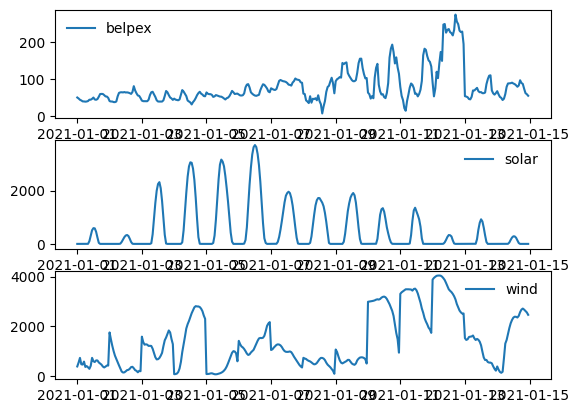

In [ ]:
start = datetime.datetime(2021, 1, 1, 0, 0)
end = datetime.datetime(2021, 1, 14, 23, 45)

plt.figure()
plt.subplot(311)
plt.plot(data.belpex[start:end], label='belpex')
plt.legend(frameon=False)
plt.subplot(312)
plt.plot(data.solar[start:end], label='solar')
plt.legend(frameon=False)
plt.subplot(313)
plt.plot(data.wind[start:end], label='wind')
plt.legend(frameon=False)
plt.show()

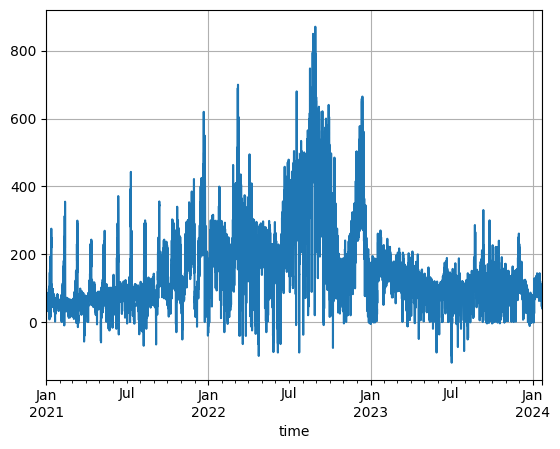

In [ ]:
plt.figure()
data.belpex.plot(grid=True)
plt.show()

# 2. Clean the data by removing outliers

Outliers are mostly difficult, if not impossible, to predict. Therefore, we like to remove them. Moreover, sometimes these outliers are not even correct.

As an example you can check out the belpex price of the year 2011.

<Axes: >

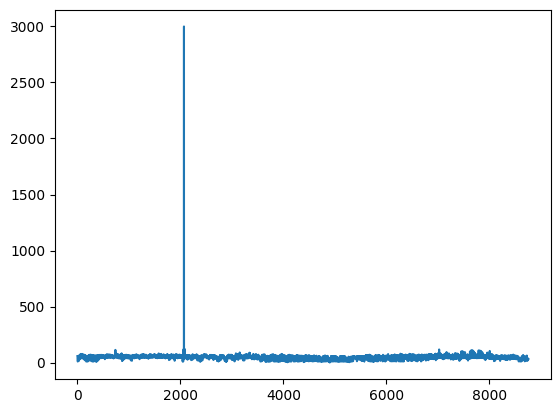

In [ ]:
df = pd.read_csv(io.BytesIO(uploaded['belpex_2011.csv']), header=0)
df.price.plot()

Read why this happened in this study of the CREG: http://www.creg.be/nl/publicaties/study-on-price-spike-on-belpex-dam-28-march-2011 .

Clue: Use a generic method from statistics that is independent of the timeseries

In [ ]:
mean = data.belpex.mean()
std = data.belpex.std()
n_std = 5
data['belpex'][(data.belpex >= mean + n_std*std)] = mean + n_std*std
data['belpex'][(data.belpex <= mean - n_std*std)] = mean + n_std*std

<ipython-input-17-d63c1dcf8f78>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['belpex'][(data.belpex >= mean + n_std*std)] = mean + n_std*std
<ipython-input-17-d63c1dcf8f78>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['belpex'][(data.belpex <= mean - n_std*std)] = mean + n_std*std


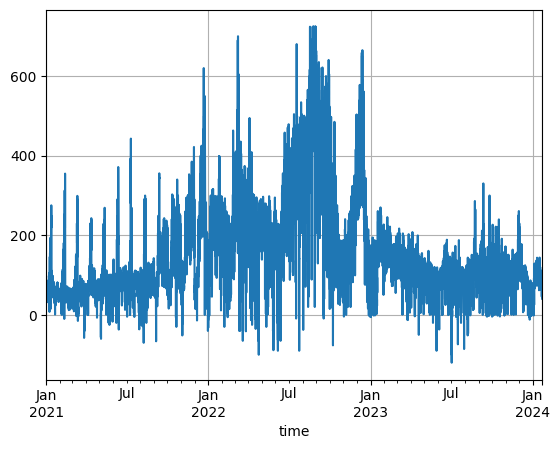

In [ ]:
plt.figure()
data.belpex.plot(grid=True)
plt.show()

# 3. Create boxplot

It is always useful to get more insight in the data you are using.

Create a boxplot grouped by
* days in the week
* months
* hours
* years

http://pandas.pydata.org/pandas-docs/version/0.13.1/visualization.html

A pandas dataframe has a table like structure. The very first column in the table contains the indices, uniquely identifying each row in the table. These indices can be a set of integers, or like in this case, a set of timestamps, points in time when the specified data was realised.

'data.index' will return all timestamps of the dataset as an array. These timestamps have certain attributes available. For a reference, see:
http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DatetimeIndex.html

Below, attributes of the datetime indices are stored in a new column of the table. This allows us to create box plots grouped by these attributes, such as day of the week, hour, etc.

<Axes: title={'center': 'belpex'}, xlabel='month_days'>

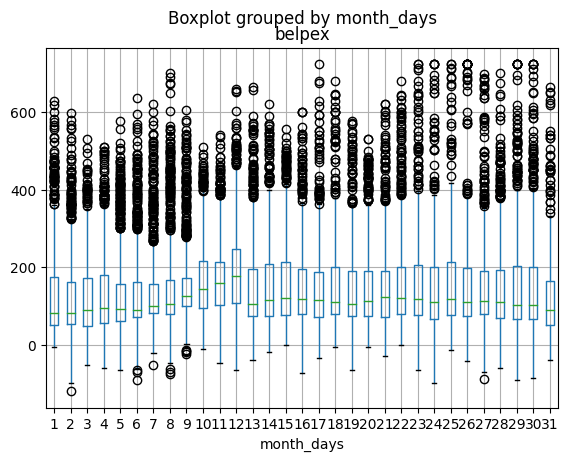

In [ ]:
data['week_days']=data.index.weekday
data['month_days']=data.index.day
data['hours']=data.index.hour
data['months']=data.index.month

data.boxplot(column='belpex', by='month_days')

<Axes: title={'center': 'belpex'}, xlabel='week_days'>

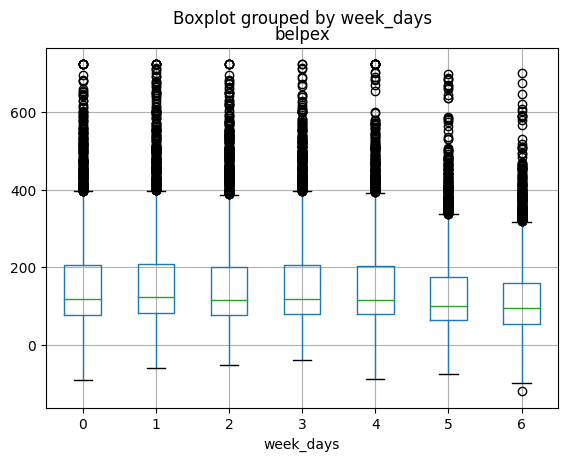

In [ ]:
data.boxplot(column='belpex', by='week_days')

<Axes: title={'center': 'belpex'}, xlabel='hours'>

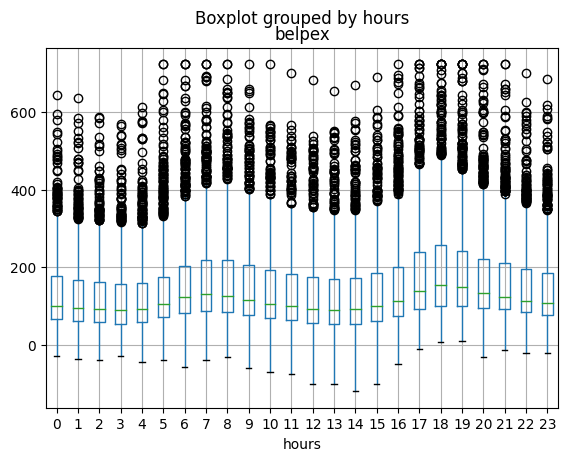

In [ ]:
data.boxplot(column='belpex', by='hours')

<Axes: title={'center': 'belpex'}, xlabel='months'>

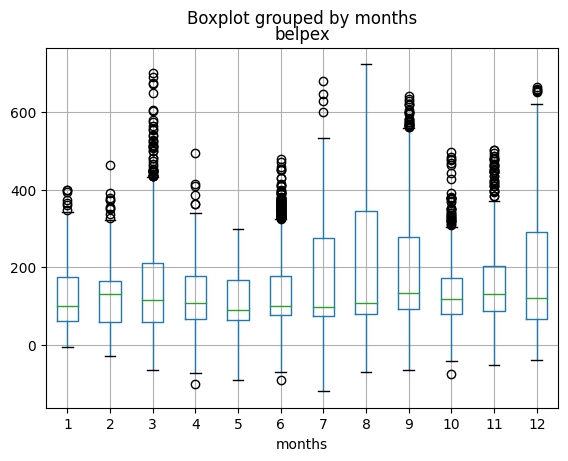

In [ ]:
data.boxplot(column='belpex', by='months')

Finally, <b>give it a try yourself</b>. Make a boxplot grouped by the year.

# 4. Check for randomness in the time series using an autocorrelation plot

This is done by computing autocorrelations for data values at varying time lags. If time series is random, such autocorrelations should be near zero for any and all time-lag separations. If time series is non-random then one or more of the autocorrelations will be significantly non-zero.

The autocorrelation is the correlation of a timeseries with a delayed copy of itself and is given by:
\begin{equation}
R(\tau) = \frac{E[(X_{t}-\mu)(X_{t+\tau}-\mu)]}{\sigma^2}
\end{equation}
where $X_t$ is the time series and $\tau$ is the time-lag.

How to make an autocorrelation plot using pandas in python:
http://pandas.pydata.org/pandas-docs/stable/visualization.html#visualization-autocorrelation

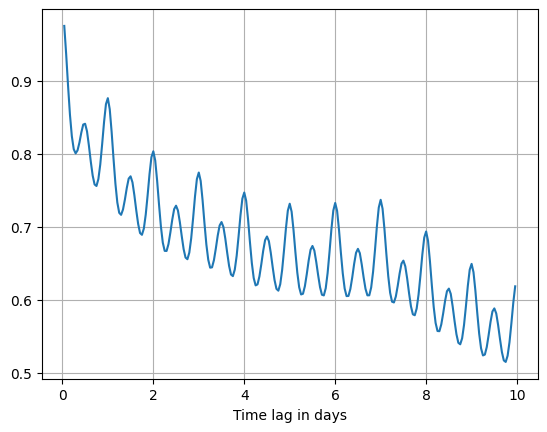

In [ ]:
# Autocorrelation
lags = np.arange(1, 24*1*10)
acors = []
for lag in lags:
    acors.append(data.belpex.autocorr(lag))
plt.figure()
plt.plot(lags/1/24.0, acors)
plt.xlabel('Time lag in days')
plt.grid(True)

# 5. Create a scatter matrix

<b>Why use a scatter plot matrix?</b>

You have three types of data:
* electricity price $p$
* solar generation $s$
* wind generation $w$

For certain moments in time, we have three data points. This means we could think of our dataset as points in a four-dimensional space:
$$\begin{Bmatrix}t\\p\\s\\w\end{Bmatrix}$$

Unless you can think of your dataset in four dimensions, let's make it a bit easier. First, we strip away the time dimension. This leaves us with a more dense three-dimensional space containing all our samples. Still, we don't like to think in three dimensions. So let's just try all possible pairs of the remaining dimensions.

We visualize each pair with a scatter plot. A scatter plot is simply a graph with dots, which are not connected. Hence, we get a matrix of scatter plots, a scatter matrix.

We do all of this to explore our dataset, and find relationships in our data. For example, if the 'price vs solar generation' scatter plot shows dots centered around a straight line, then we can conclude that there is a linear relationship between price and solar generation. This is something that we could exploit later on, when we make our model.

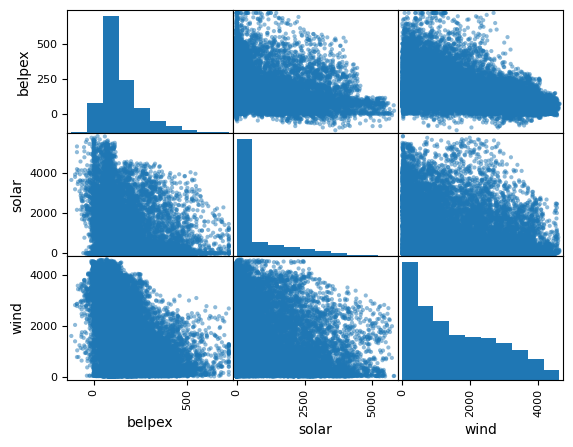

In [ ]:
import pandas as pd
a = pd.plotting.scatter_matrix(data[['belpex', 'solar', 'wind']])

If the diagonal is not what you would expect, then you are right. For more information, see

http://stackoverflow.com/questions/26360759/understanding-the-diagonal-in-pandas-scatter-matrix-plot

# 6. Linear regression

Metric to define the quality of the foreceast

In [ ]:
def get_accuracy(x, y):
    return np.mean(np.abs(x - y))/np.mean(x)

In this section, we will use the scikit learn toolbox. For more information, see
* [API reference](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection)
* [Tutorials](http://scikit-learn.org/stable/tutorial/index.html)

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge
model = LinearRegression()
lags = [24*1] + list(range(24*1*7, 24*1*35, 24*1))
features = ['wind', 'solar']
print(lags)
len(lags)

[24, 168, 192, 216, 240, 264, 288, 312, 336, 360, 384, 408, 432, 456, 480, 504, 528, 552, 576, 600, 624, 648, 672, 696, 720, 744, 768, 792, 816]


29

In [ ]:
index = data.index
for lag in lags:
    data['belpex_lag_{}'.format(lag)] = data.belpex.shift(lag)
    features.append('belpex_lag_{}'.format(lag))
data['day_in_year'] = data.index.dayofyear
data = data.loc[index, :]
data = data.dropna()

X = data[features]
y = data.belpex

cv = KFold(n_splits=10, shuffle=False)
data['belpex_pred'] = cross_val_predict(model, X, y, cv=cv, n_jobs=-1)

print(get_accuracy(data.belpex, data.belpex_pred))


0.2249128504387558


In [ ]:
print(features)

['wind', 'solar', 'belpex_lag_24', 'belpex_lag_168', 'belpex_lag_192', 'belpex_lag_216', 'belpex_lag_240', 'belpex_lag_264', 'belpex_lag_288', 'belpex_lag_312', 'belpex_lag_336', 'belpex_lag_360', 'belpex_lag_384', 'belpex_lag_408', 'belpex_lag_432', 'belpex_lag_456', 'belpex_lag_480', 'belpex_lag_504', 'belpex_lag_528', 'belpex_lag_552', 'belpex_lag_576', 'belpex_lag_600', 'belpex_lag_624', 'belpex_lag_648', 'belpex_lag_672', 'belpex_lag_696', 'belpex_lag_720', 'belpex_lag_744', 'belpex_lag_768', 'belpex_lag_792', 'belpex_lag_816']


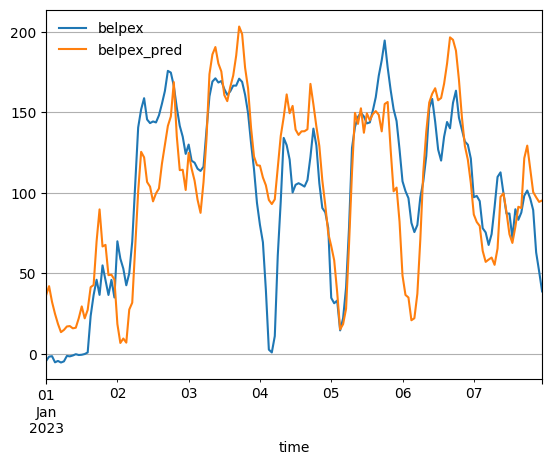

In [ ]:
start = datetime.datetime(2023, 1, 1, 0, 0)
end = datetime.datetime(2023, 1, 7, 23, 45)

plt.figure()
data.belpex[start:end].plot(grid=True)
data.belpex_pred[start:end].plot(grid=True)
plt.legend(frameon=False,loc=2)
plt.show()

# 7. Neural network (a naive implementation)

In [ ]:
import os

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop, SGD


Create input and output training data. <br>
We will just predict the next day, based on the previous day.

In [ ]:
n_hours = 24
start = datetime.datetime(2023, 1, 1, 0, 0)
end = datetime.datetime(2023, 12, 29, 23, 45)
X = data['belpex'][start:end].resample('1H').mean().values.reshape(-1, n_hours)


start = datetime.datetime(2023, 1, 2, 0, 0)
end = datetime.datetime(2023, 12, 30, 23, 45)
Y = data['belpex'][start:end].resample('1H').mean().values.reshape(-1, n_hours)

In [ ]:
print(data['belpex'][start:end].resample('1H').mean().shape)

(8712,)


In [ ]:
print('input_features ' + str(X.shape))
print('target dimensions ' + str(Y.shape))

input_features (363, 24)
target dimensions (363, 24)


Create neural network with one hidden layer

In [ ]:
neurons = [24, 24 ]
activation_functions = ['relu', 'linear']

model = Sequential()
model.add(Dense(neurons[0], input_dim=X.shape[1], activation=activation_functions[0]))
model.add(Dense(neurons[1], activation=activation_functions[1]))

rprop = RMSprop(lr=0.001, rho=0.9, epsilon=1e-6)
model.compile(loss='mean_squared_error', optimizer=rprop)

In [ ]:
output_training = model.fit(X, Y, epochs=500, batch_size=32, verbose=0)
mse = output_training.history['loss'][-1]
print('- mse is %.4f' % mse + ' @ ' + str(len(output_training.history['loss'])))

- mse is 546.9435 @ 500


In [ ]:
predict_nn = model.predict(X)

print(get_accuracy(Y.flatten(), predict_nn.flatten()))


12/12 [==============================] - 0s 2ms/step
0.17104411725012184


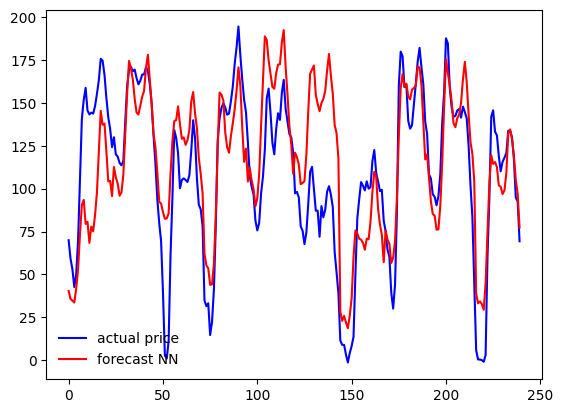

In [ ]:
# Plots
plt.figure()
plt.plot(Y[:10,:].flatten(), color='blue', label='actual price')
plt.plot(predict_nn[:10,:].flatten(), color='red', label='forecast NN')
plt.legend(frameon=False)
plt.show()

# 8. Assignment: Improve the naive implementation in Step 7


* Create test and validation set
    * https://en.wikipedia.org/wiki/Test_set
    * http://stats.stackexchange.com/questions/19048/what-is-the-difference-between-test-set-and-validation-set
* Add additional features
    * same day of the previous week (see autocorrelation plot)
    * use a wind and solar forecast as an additional feature (assume you can make perfect forecasts)
    * Use EliaTotalLoad from datafetcher
    * Are there other features that have an influence on the price and thus may affect prediction performance
* Tune the structure of the neural network (use grid search)
    * number of layers
        * http://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw
    * different activation functions
        * https://en.wikipedia.org/wiki/Activation_function

Advice: read the documentation on https://keras.io/ for help